In [386]:
import os

path = os.path.join(os.path.dirname(os.getcwd()), "data")
msp_file = os.path.join(path, "MoNA-export-GC-MS.msp")

In [387]:
from matchms.filtering import normalize_intensities
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import require_minimum_number_of_peaks
import random

def apply_my_filters(s):
    s = normalize_intensities(s)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    return s

def group_by_inchikey(spectrums):
    grouped_spectrum = []
    inchikeys = []
    for s in spectrums:
        inchikey = s.metadata.get('inchikey').split('-', 1)[0]
        if inchikey not in inchikeys:
            inchikeys.append(inchikey)
            grouped_spectrum.append([s]) 
        else:
            index = inchikeys.index(inchikey)
            grouped_spectrum[index].append(s)
    return grouped_spectrum

def separate_by_same_inchikey(spectrums):
    return random.sample([k for k in group_by_inchikey(spectrums) if len(k) == 2], 1000)

def separate_by_diff_inchikey(spectrums):
    # grouped_spectrum = group_by_inchikey(spectrums)
    # shuffled1 = random.sample(grouped_spectrum, len(grouped_spectrum))
    # shuffled2 = random.sample(grouped_spectrum, len(grouped_spectrum))
    # selectec_spectra = []
    # for n in range(0, 1000):
    #     selectec_spectra.append([shuffled1[n][0], shuffled2[n][0]])
    # return selectec_spectra

    selected_spectrum = [[g[0]] for g in spectrums]
        
    for k, e in enumerate(selected_spectrum):
        diff_mol = random.sample(spectrums, 1)
        while e[0].metadata['inchikey'].split(',', 1)[0] == diff_mol[0][1].metadata['inchikey'].split(',', 1)[0]:
            diff_mol = random.sample(spectrums, 1)
        selected_spectrum[k].append(diff_mol[0][1])

    return selected_spectrum

In [388]:
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
import numpy as np

def calculate_similarity_scores(group_spectra, show_data = False):
    scores_hist = []
    for k, spectrums in enumerate(group_spectra):
        scores = calculate_scores(references=spectrums,
                                queries=spectrums,
                                similarity_function=CosineGreedy())
        
        for k, score in enumerate(scores):
            if k == 1:
                (reference, query, score, n_matching) = score
                
                scores_hist.append({'reference':reference, 'query':query, 'score':score, 'n_matching':n_matching})
                
                if show_data:
                    print(f"Reference scan name: {reference.metadata['name']} - Query scan name: {query.metadata['name']}")
                    print(f"Reference InChiKey: {reference.metadata['inchikey']} - Query InChiKey: {query.metadata['inchikey']}")
                    print(f"Score: {score:.4f}")
                    print(f"Number of matching peaks: {n_matching}")
                    print("----------------------------")

    return np.array(scores_hist)

In [389]:
from matchms.importing import load_from_msp

def get_gcms_data():
    spectrums = [apply_my_filters(s) for s in load_from_msp(msp_file)]

    return [s for s in spectrums if s is not None]

def get_grouped_spectra(spectra, show_data = False):
    group_spectra = separate_by_same_inchikey(spectra)
    group_spectra2 = separate_by_diff_inchikey(group_spectra)

    return [
       {
            "data": group_spectra,
            "scores": calculate_similarity_scores(group_spectra, show_data)
        },
        {
            "data": group_spectra2,
            "scores": calculate_similarity_scores(group_spectra2, show_data)
        },
    ]

In [390]:
import matplotlib.pyplot as plt
from typing import List

def print_histogram(data):
    plt.figure(figsize=(12,7))
    hist = plt.hist(data)
    plt.xlabel("Scores")
    plt.ylabel("Number of pairs Spectra")
    plt.show()
    
def plot_mirror_histogram(same_mols: List[float], diff_mols: List[float],
                          start_limx=None, end_limx=None,
                          start_limy=None, end_limy=None):
    
    plt.figure(figsize=(12,7))
    fig, [ax1, ax2] = plt.subplots(2,1, sharex=True, figsize=(12,7))
    fig.text(0.5, 0.04, 'Scores', ha='center')
    fig.text(0.04, 0.5, 'Num. of Pair Spectra', va='center', rotation='vertical')
    plt.subplots_adjust(hspace=0.0)
    ax1.hist(same_mols)
    
        
    if start_limx is not None and end_limx is not None:
        ax1.set_xlim(start_limx, end_limx)
    
    if start_limy is not None and end_limy is not None:
        ax1.set_ylim(start_limy, end_limy)

    plt.hist(diff_mols, color='#f9ad37')
    if start_limx is not None and end_limx is not None:
        ax2.set_xlim(start_limx, end_limx)
    
    if start_limy is not None and end_limy is not None:
        ax2.set_ylim(end_limy, start_limy)
    else:
        ax2.set_ylim(ax2.get_ylim()[::-1])
        
    plt.show()

In [391]:
def show_data(spectra, title=None):
    group_spectra = get_grouped_spectra(spectra)
    if title is not None:
        print(title)
    plot_mirror_histogram(group_spectra[0]['scores'], group_spectra[1]['scores'], 0, 1000)
    print_histogram(group_spectra[0]['scores'])
    print_histogram(group_spectra[1]['scores'])

In [392]:
spectra = get_gcms_data()

In [393]:
grouped_spectra = get_grouped_spectra(spectra)

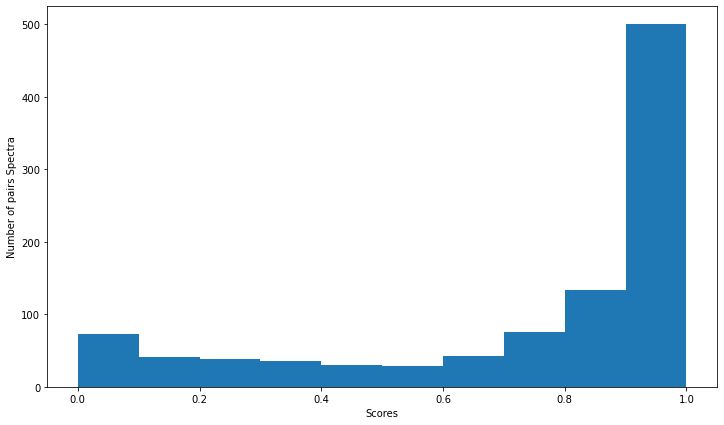

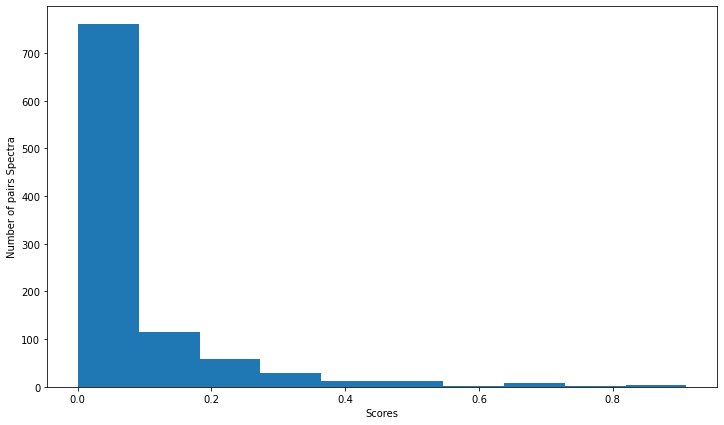

In [394]:
scores1 = [g['score'] for g in grouped_spectra[0]['scores']]
scores2 = [g['score'] for g in grouped_spectra[1]['scores']]

print_histogram(scores1)
print_histogram(scores2)

In [395]:
def print_mirror_plot(score):
    sample = random.sample(score, 1)
    spectrum1 = sample[0]['reference']
    spectrum2 = sample[0]['query']

    fig, [ax1, ax2] = plt.subplots(2,1, figsize=(12,7))
    subtitle = 'Top: ' + spectrum1.metadata['name'] + '\n' + 'Bottom: ' + spectrum2.metadata['name'] + '\n' + 'Cosine Similarity: ' + str(sample[0]['score']) + '\n'
    fig.suptitle(subtitle, fontsize=16)
    fig.text(0.5, 0.04, 'm/z', ha='center')
    fig.text(0.04, 0.5, 'Intensities', va='center', rotation='vertical')

    plt.subplots_adjust(hspace=0.0)
    ax1.bar(spectrum1.peaks.mz, spectrum1.peaks.intensities)

    ax2 = plt.subplot(212)
    plt.bar(spectrum2.peaks.mz, spectrum2.peaks.intensities, color='#f9ad37')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    plt.show()
    
scores = [g for g in grouped_spectra[0]['scores'] if g['score'] < 0.1]

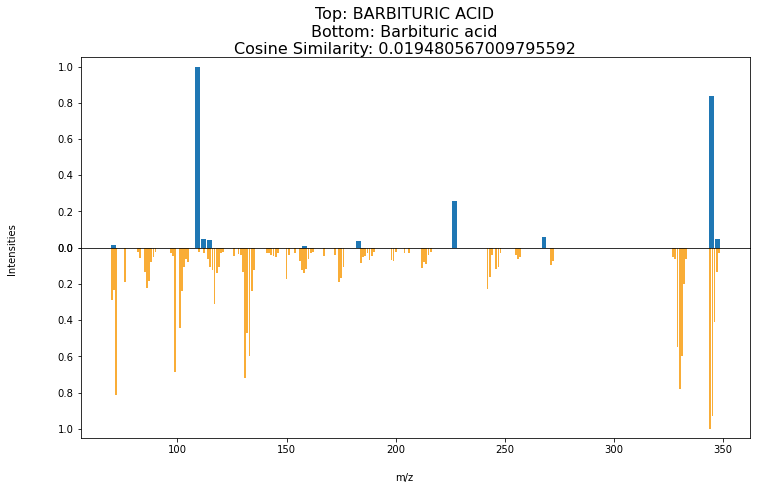

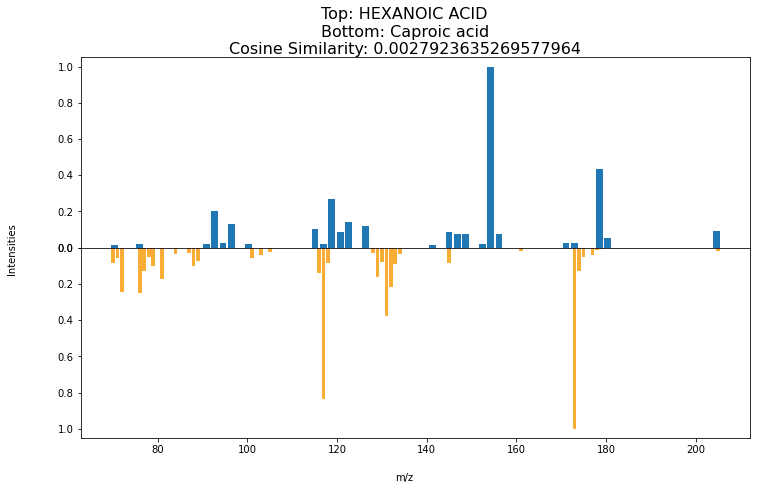

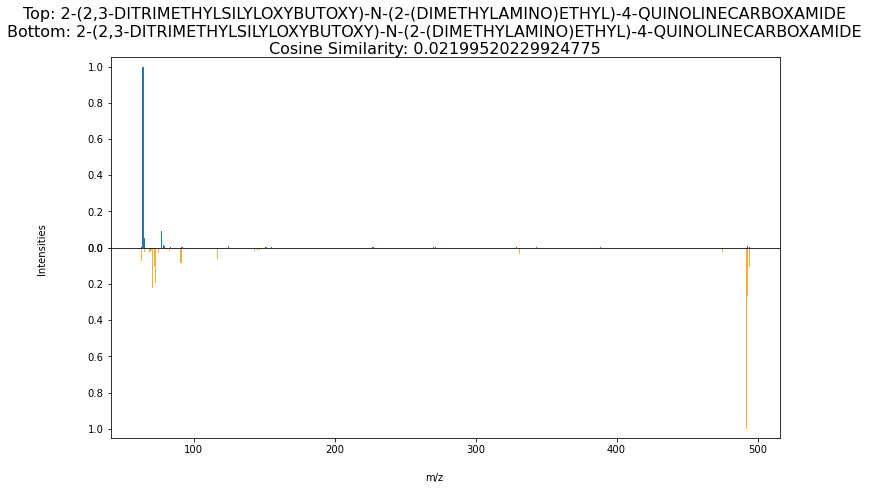

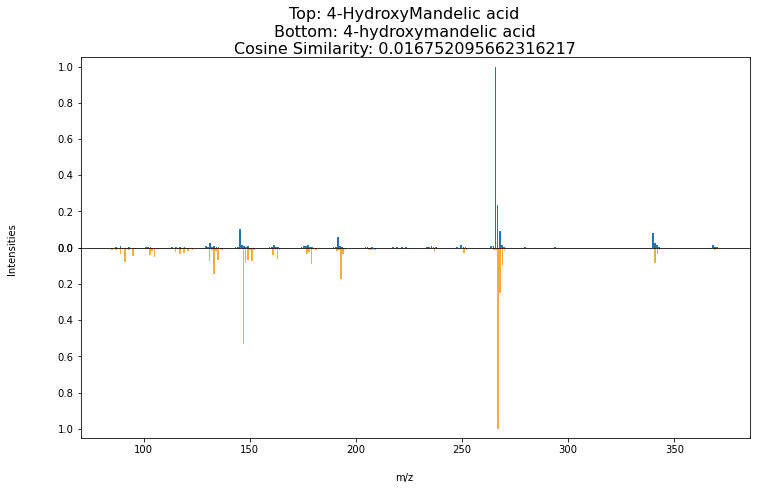

In [401]:
print_mirror_plot(scores)
print_mirror_plot(scores)
print_mirror_plot(scores)
print_mirror_plot(scores)